In [24]:
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
from cupyx.scipy import ndimage
from projection import R

%matplotlib inline

In [25]:
n = 256 # object size in 1 dimension

## Generate a 3D ALD standard cube

In [26]:
cube_all = cp.zeros([n,n,n],dtype='float32')
rr = (cp.ones(8)*8/5*n*0.2).astype(np.int32)
amps = [3, 2, -3, 1, 2,-4,2]#, -2, -4, 5 ]
dil = np.array([30, 28, 25, 21, 16,10,3])*n/256#, 6, 3,1]
for kk in range(len(amps)):
    cube = cp.zeros([n,n,n],dtype='bool')
    r = rr[kk]
    p1 = n//2-r//2
    p2 = n//2+r//2
    for k in range(3):    
        cube = cube.swapaxes(0,k)
        cube[p1:p2,p1,p1] = True
        cube[p1:p2,p1,p2] = True
        cube[p1:p2,p2,p1] = True
        cube[p1:p2,p2,p2] = True        
        #cube[p1:p2,p2,p2] = True        
        
    [x,y,z] = cp.meshgrid(cp.arange(-n//2,n//2),cp.arange(-n//2,n//2),cp.arange(-n//2,n//2))
    circ = (x**2+y**2+z**2)<dil[kk]**2        
    fcirc = cp.fft.fftshift(cp.fft.fftn(cp.fft.fftshift(circ)))
    fcube = cp.fft.fftshift(cp.fft.fftn(cp.fft.fftshift(cube.astype('float32'))))
    cube = cp.fft.fftshift(cp.fft.ifftn(cp.fft.fftshift(fcube*fcirc))).real
    cube = cube>1
    cube_all+=amps[kk]*cube

cube_all = ndimage.rotate(cube_all,52,axes=(1,2),reshape=False,order=1)
cube_all = ndimage.rotate(cube_all,38,axes=(0,1),reshape=False,order=1)
cube_all = ndimage.rotate(cube_all,10,axes=(0,2),reshape=False,order=1)
cube_all[cube_all<0] = 0
u0 = cube_all

!mkdir -p data
np.save('data/u',u0.get())
u = u0

u = cp.array(np.load('data/u.npy')) # if already exists

## Plot vertical and horizontal slices throught the object

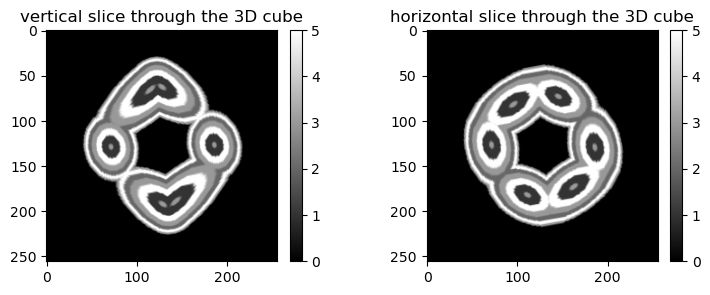

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(9, 3))
im = axs[0].imshow(u[n//2].get(), cmap='gray')
axs[0].set_title('vertical slice through the 3D cube')
fig.colorbar(im, fraction=0.046, pad=0.04)
im = axs[1].imshow(u[:,n//2].get(), cmap='gray')
axs[1].set_title('horizontal slice through the 3D cube')
fig.colorbar(im, fraction=0.046, pad=0.04)
plt.show()

## Generate tomography projections

In [28]:
ntheta =180 # number of rotation angles
center = n/2 # rotation center
theta = cp.linspace(0,np.pi,ntheta) # projection angles

Ru = R(u,theta,center)

## Plot projection for angle 0 and angle ntheta//2 (90 deg)

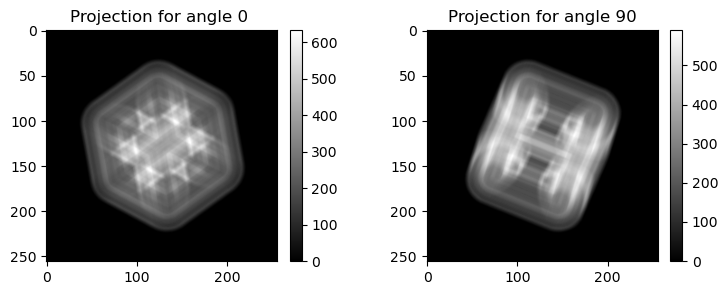

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(9, 3))
im = axs[0].imshow(Ru[0].get(), cmap='gray')
axs[0].set_title('Projection for angle 0 ')
fig.colorbar(im, fraction=0.046, pad=0.04)
im = axs[1].imshow(Ru[ntheta//2].get(), cmap='gray')
axs[1].set_title('Projection for angle 90')
fig.colorbar(im, fraction=0.046, pad=0.04)
plt.show()